# HealthCare ML Project
## 1. import  Data & libraries

In [147]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb 
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu


In [7]:
df=pd.read_csv('data/training_v2.csv')

In [8]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


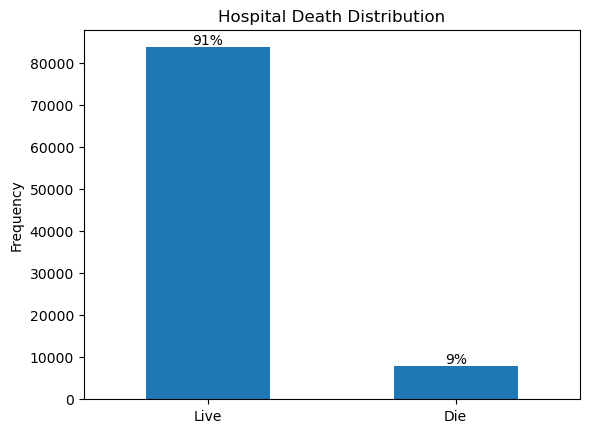

In [17]:
# Assuming data is your DataFrame with the "hospital_death" column
df["hospital_death"].value_counts().sort_index().plot(kind='bar')

# Adding labels and title
plt.ylabel('Frequency')
plt.title('Hospital Death Distribution')

# Adding percentage annotations on top of the bars
total_count = len(df["hospital_death"])
for i, count in enumerate(df["hospital_death"].value_counts().sort_index()):
    percent = count / total_count * 100
    plt.text(i, count + 20, f'{percent:.0f}%', ha='center', va='bottom')
plt.xticks([0,1],["Live",'Die'],rotation=0)
# Show the plot
plt.show()

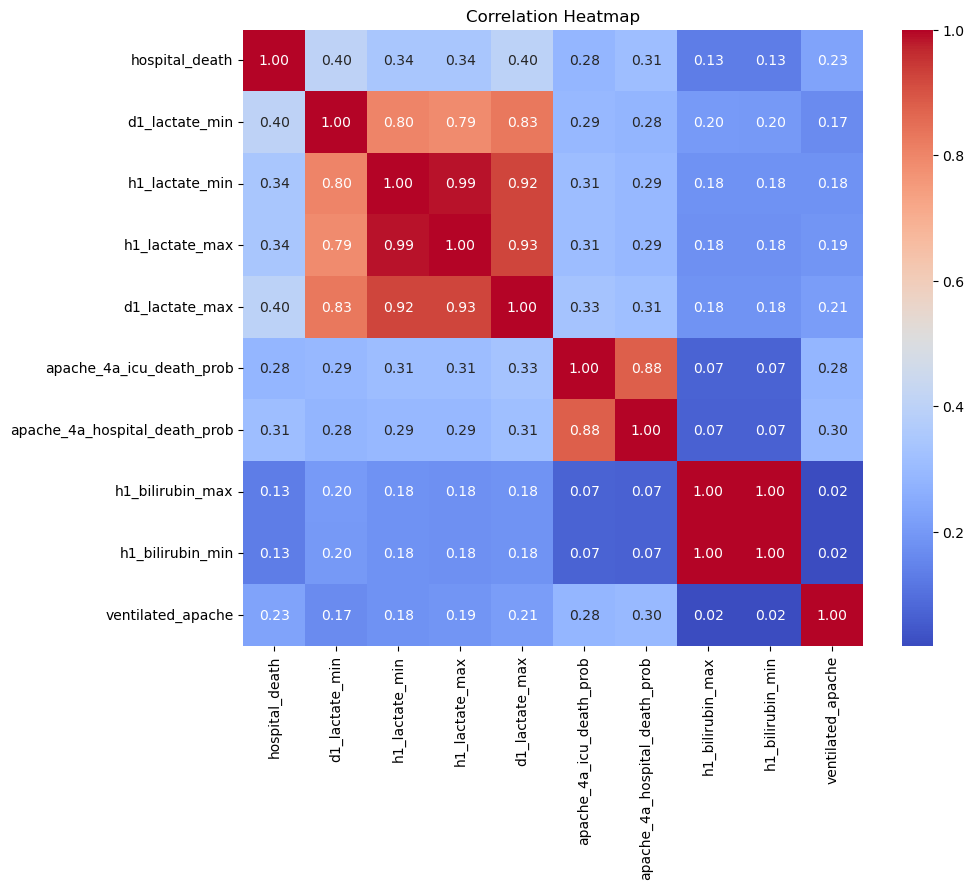

In [45]:
numeric_columns = df.iloc[:1000].select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_columns.corr('spearman')

# Sort the correlation with respect to "hospital_death"
correlation_with_target = correlation_matrix['hospital_death'].sort_values(ascending=False)

# Select the top N most highly correlated columns (adjust N as needed)
top_correlated_columns = correlation_with_target.head(10)  # You can change 10 to any desired number

# Create a subset DataFrame with the top correlated columns
subset_df = df[top_correlated_columns.index]
# Create a DataFrame containing only the first row of the correlation matrix
first_row_df = pd.DataFrame(correlation_matrix.iloc[0, :]).transpose()

# Create a heatmap
plt.figure(figsize=(10, 8))
sb.heatmap(subset_df.corr(), annot=True, cmap='coolwarm', fmt=".2f")

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

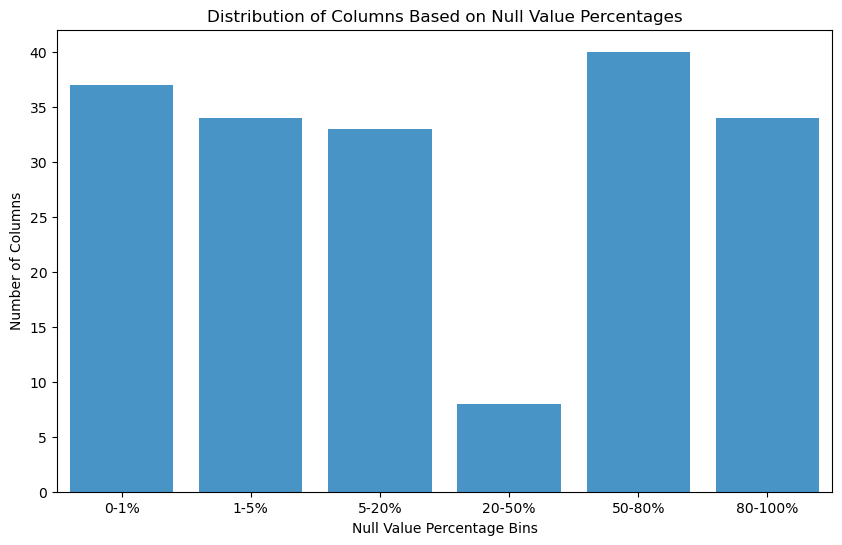

In [94]:
# Calculate the percentage of null values in each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Define the bins for categorization
bins = [-0.1, 1, 5, 20, 50, 80, 100]

# Create a new column indicating the bin for each column
bin_labels = ['0-1%', '1-5%', '5-20%', '20-50%', '50-80%', '80-100%']
null_bins = pd.cut(null_percentages, bins, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = null_bins.value_counts().sort_index()

# Create a bar plot
plt.figure(figsize=(10, 6))
sb.barplot(x=bin_counts.index, y=bin_counts.values,color='#3498db')
plt.xlabel('Null Value Percentage Bins')
plt.ylabel('Number of Columns')
plt.title('Distribution of Columns Based on Null Value Percentages')
plt.show()

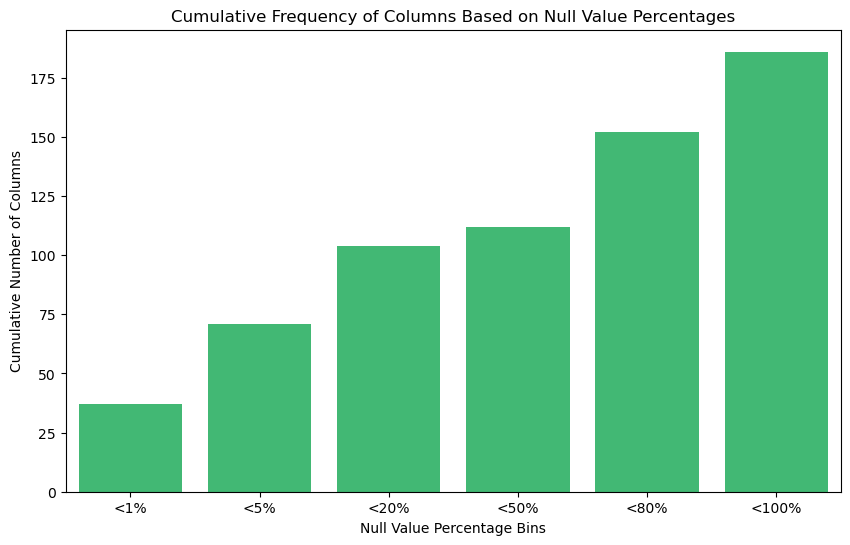

In [95]:
# Calculate the percentage of null values in each column
null_percentages = (df.isnull().sum() / len(df)) * 100

# Define the bins for categorization
bins = [-0.1, 1, 5, 20, 50, 80, 100]

# Create a new column indicating the bin for each column
bin_labels = ['<1%', '<5%', '<20%', '<50%', '<80%', '<100%']
null_bins = pd.cut(null_percentages, bins, labels=bin_labels)

# Count the number of columns in each bin
bin_counts = null_bins.value_counts().sort_index()

# Calculate the cumulative frequency
cumulative_freq = bin_counts.cumsum()

# Create a bar plot for cumulative frequency
plt.figure(figsize=(10, 6))
sb.barplot(x=cumulative_freq.index, y=cumulative_freq.values, color='#2ecc71')
plt.xlabel('Null Value Percentage Bins')
plt.ylabel('Cumulative Number of Columns')
plt.title('Cumulative Frequency of Columns Based on Null Value Percentages')
plt.show()

In [ ]:
## Seperation Test 

In [142]:
#define  continious and binary columns
binary_columns = df.columns[(df.nunique() <= 4) ]
continious_columns= df.columns[(df.nunique() >=10) & ((df.dtypes == 'int64')|(df.dtypes == 'float64'))]


In [171]:
group1 = df[df["hospital_death"] == 0]
group2 = df[df["hospital_death"] == 1]

# Create a DataFrame to store p-values, means, and percentage differences
result_df = pd.DataFrame(columns=['Column', 'P-Value', 'Mean_Group_live', 'Mean_Group_die', 'Percentage Difference'])

# Iterate through each column in the DataFrame
for column in continious_columns:
    if column != "hospital_death":
        # Perform the Mann-Whitney U test for the current column
        stat, p_val = mannwhitneyu(group1[column].dropna(), group2[column].dropna(), alternative='two-sided')
        
        # Calculate the mean for each group
        mean_group1 = group1[column].mean()
        mean_group2 = group2[column].mean()
        
        # Calculate the percentage difference between the means
        percentage_difference = (np.abs(mean_group1 - mean_group2) / ((mean_group1 + mean_group2) / 2)) * 100
        
        # Store the results in the DataFrame
        result_df = pd.concat([result_df, pd.DataFrame({'Column': [column], 
                                                        'P-Value': [np.round(p_val, 3)], 
                                                        'Mean_Group_live': [np.round(mean_group1, 2)],
                                                        'Mean_Group_die': [np.round(mean_group2, 2)],
                                                        'Percentage Difference': [np.round(percentage_difference, 2)]})],
                              ignore_index=True)

# # Adjust p-values for multiple testing (e.g., using Benjamini-Hochberg correction)
# result_df['Adjusted P-Value'] = multipletests(result_df['P-Value'], method='fdr_bh')[1]

# Display the resulting DataFrame


,Column,P-Value,Mean_Group_live,Mean_Group_die,Percentage Difference
53,d1_temp_max,0.099,37.28,37.30,0.04
45,d1_spo2_max,0.000,99.25,99.19,0.05
138,h1_sodium_min,0.582,137.89,137.99,0.07
108,d1_sodium_min,0.036,137.73,137.61,0.09
137,h1_sodium_max,0.712,138.22,138.39,0.12
31,d1_diasbp_max,0.037,88.48,88.61,0.15
6,icu_id,0.679,508.29,509.10,0.16
25,sodium_apache,0.573,137.94,138.19,0.18
33,d1_diasbp_noninvasive_max,0.057,88.59,88.78,0.21
2,hospital_id,0.665,105.69,105.41,0.27


In [172]:
result_df.sort_values(by='Percentage Difference',ascending=False).head(20)

,Column,P-Value,Mean_Group_live,Mean_Group_die,Percentage Difference
158,apache_4a_icu_death_prob,0.0,0.02,0.24,162.92
157,apache_4a_hospital_death_prob,0.0,0.06,0.33,136.76
101,d1_lactate_max,0.0,2.37,5.62,81.40
102,d1_lactate_min,0.0,1.74,3.99,78.77
132,h1_lactate_min,0.0,2.56,5.14,67.14
131,h1_lactate_max,0.0,2.60,5.20,66.61
83,d1_bilirubin_max,0.0,1.03,1.97,62.66
12,bilirubin_apache,0.0,1.04,1.99,62.34
84,d1_bilirubin_min,0.0,0.98,1.80,59.42
113,h1_bilirubin_max,0.0,0.99,1.76,56.16


In [173]:
result_df[result_df["Column"]=='age']

,Column,P-Value,Mean_Group_live,Mean_Group_die,Percentage Difference
3,age,0.0,61.75,68.49,10.36


In [177]:

result_df["Column"].to_list()

['encounter_id',
 'patient_id',
 'hospital_id',
 'age',
 'bmi',
 'height',
 'icu_id',
 'pre_icu_los_days',
 'weight',
 'albumin_apache',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'bilirubin_apache',
 'bun_apache',
 'creatinine_apache',
 'fio2_apache',
 'glucose_apache',
 'heart_rate_apache',
 'hematocrit_apache',
 'map_apache',
 'paco2_apache',
 'paco2_for_ph_apache',
 'pao2_apache',
 'ph_apache',
 'resprate_apache',
 'sodium_apache',
 'temp_apache',
 'urineoutput_apache',
 'wbc_apache',
 'd1_diasbp_invasive_max',
 'd1_diasbp_invasive_min',
 'd1_diasbp_max',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_max',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_invasive_max',
 'd1_mbp_invasive_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_invasive_max',
 'd1_sysbp_invasive_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvas